# Analisis exploratorio y preprocesamiento de los datos

## Lectura y union de los archivos *.parquet

In [22]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

In [23]:
path = '../data/raw/Lecturas_Eneero_2025'
content = os.listdir(path)
files = []
no_empty = []
# Create DataFrame
df = pd.DataFrame(
{
    'ReadId': [],
    'TimeSpan': [],
    'SensorId': [],
    'Value': [],
    'LocalTimeSpan': [],
})

for folder in content:
    if folder.endswith(''):
        path_files = os.path.join(path,folder)
        for file in os.listdir(path_files):
            if file.endswith('parquet'):
                files.append(file)
                try:
                    df_1 = pd.read_parquet(os.path.join(path_files,file))
                    df = pd.concat([df,df_1])
                    no_empty.append(file)
                except OSError:
                    pass

df = df.reset_index(drop=True)        
print(f"Total files (*.parquet) found: {len(files)}, Total non-empty files: {len(no_empty)}")

Total files (*.parquet) found: 7492, Total non-empty files: 5173


## Preprocesamiento de los datos
### Lecturas de los sensores

In [24]:
# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165411 entries, 0 to 165410
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ReadId         165411 non-null  object        
 1   TimeSpan       165411 non-null  datetime64[ns]
 2   SensorId       165411 non-null  object        
 3   Value          165411 non-null  float64       
 4   LocalTimeSpan  165411 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 6.3+ MB


In [25]:
# Verify null values per column
print(df.isna().sum())

ReadId           0
TimeSpan         0
SensorId         0
Value            0
LocalTimeSpan    0
dtype: int64


No hay valores ausentes y las columnas tienen el formato adecuado.

In [26]:
# Show DataFrame
df.head(5)

,ReadId,TimeSpan,SensorId,Value,LocalTimeSpan
0,05543cf3-ec51-4760-a9af-8efa01a203e6,2025-01-18 13:48:44.190,063276ed-657e-40a2-a17b-0c685af518f6,31.20,2025-01-18 07:48:44.190
1,a3c80788-c698-41cc-835f-aedd98adb72c,2025-01-18 13:48:44.195,22f8b472-4022-41a9-b7b7-37e83a532df0,35.55,2025-01-18 07:48:44.195
2,4e223d79-4791-4c2a-9d88-97c8efa170bc,2025-01-18 13:48:44.199,267e3d44-9b7f-460c-b34b-603fe0fa9972,36.90,2025-01-18 07:48:44.199
3,1cc74f1d-89bf-47d0-81a9-4de727f9f1e4,2025-01-18 13:48:44.202,8139d3c7-5a4c-40d3-b3a6-8db4da769001,41.55,2025-01-18 07:48:44.202
4,29cc45c7-eed9-4901-8fe1-1423c043d289,2025-01-18 13:48:44.206,d080f284-c51f-4a48-a4d7-b7acec0672ba,36.30,2025-01-18 07:48:44.206


Parece que las columnas 'TimeSpan' y 'LocalTimeSpan' solo varian por unas horas, es decir, es la misma informacion.

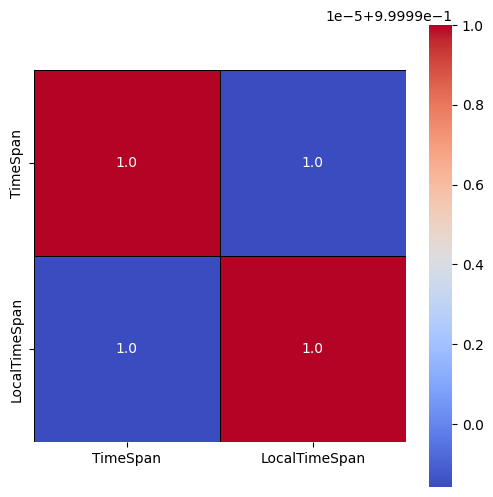

In [21]:
df_split = df[['TimeSpan','LocalTimeSpan']]

# Heatmap
plt.figure(figsize = (6,6))
sns.heatmap(df_split.corr(), annot=True, square=True, cmap='coolwarm',
            fmt='.1f',annot_kws={"size": 10}, linewidths=0.5, linecolor='black')
plt.show()

Efectivamente, las columnas 'TimeSpan' y 'LocalTimeSpan' contienen la misma informacion.

Veamos cuantos valores diferentes hay en las columnas 'ReadId' y 'SensorId'.

In [8]:
# Count unique values
print(df['ReadId'].nunique())

165407


In [9]:
# Count unique values
print(df['SensorId'].nunique())

40


In [27]:
# Delete all row duplicates
df = df.drop_duplicates()

# Count duplicates
df.duplicated().sum()

0

A continuación se verificará si existen outliers para la columna 'Value' y se procederá a
eliminar el 5% en cada extremo (menor y mayor).

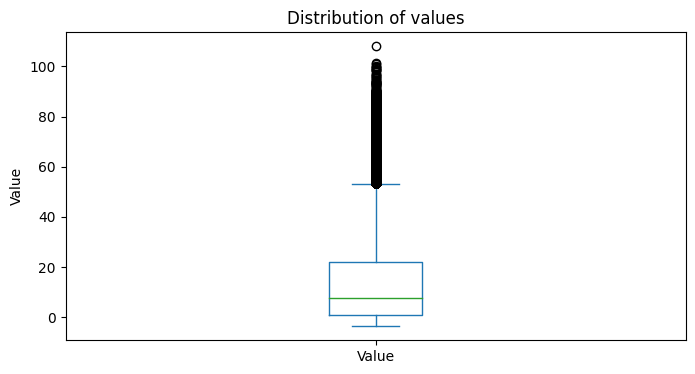

In [28]:
# Box plot
df['Value'].plot(kind='box', figsize=[8,4], title='Distribution of values',
                 ylabel='Value')
plt.xticks(rotation=0)
plt.show()

In [29]:
# Limit outliers to percentile 95
percentile95 = df['Value'].quantile(0.95)
for index,value in df['Value'].items():
    if value > percentile95:
        df.loc[index,'Value'] = percentile95

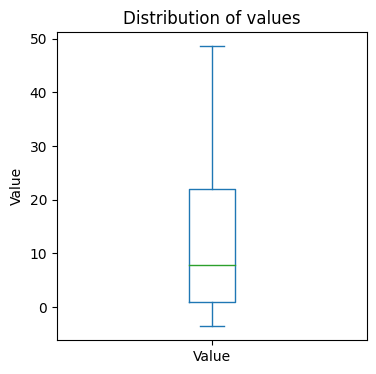

In [30]:
# Box plot
df['Value'].plot(kind='box', figsize=[4,4], title='Distribution of values',
                 ylabel='Value')
plt.xticks(rotation=0)
plt.show()

Los datos estan limpios ahora, por lo tanto se guardaran.

In [31]:
file_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# Save DataFrame
df.to_csv(f'../data/processed/enero_2025_{file_date}.csv', index=False)

## Analisis exploratorio de las tablas
Se realizara el mismo analisis mostrado en la seccion anterior.

In [32]:
# Read DataFrame
df_cities = pd.read_csv('../data/raw/dimCities.csv',sep=',',header=0)

# Show DataFrame
df_cities.head(2)

,CityId,StateId,Name
0,761AC964-F254-4E4B-0865-08DC439261D4,E30541D0-B009-4D73-E19A-08DC43924EB2,Chihuahua
1,5A5E32BC-B4B6-4496-DD37-08DD421CD4D1,E30541D0-B009-4D73-E19A-08DC43924EB2,Juárez


In [35]:
# DataFrame information
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CityId   3 non-null      object
 1   StateId  3 non-null      object
 2   Name     3 non-null      object
dtypes: object(3)
memory usage: 200.0+ bytes


In [36]:
# Read DataFrame
df_devices = pd.read_csv('../data/raw/dimDevices.csv',sep=',',header=0)

# Show DataFrame
df_devices.head(2)

,DeviceId,DeviceTyId,SubLocationId,Name,Active,ModelId,CreatedAt,ModifiedAt
0,9D5E9B81-70CE-4DD6-90D0-006F7DA796FA,C48A1D4F-664C-4863-2555-08DD462F6DF2,9F33CBEA-6D72-4E8A-615F-08DD5B605483,Cuarto de Congelación,1,D4E53753-7F96-4124-26BD-08DC43962801,2025-03-06 14:52:11.4632359,2025-03-06 14:52:11.4632359
1,ED5B45ED-142D-4B09-B7A7-0349360AEA32,0373D9FC-85A2-4324-5940-08DC84AC4EC2,8C213D36-9843-4DDC-5573-08DDDE84D8AA,Alumbrado Exterior,1,A3799BB1-C2E1-4E07-95A0-08DC84A8A9D2,2025-08-19 18:45:10.2321111,2025-08-19 18:45:10.2321111


In [37]:
# DataFrame information
df_devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DeviceId       110 non-null    object
 1   DeviceTyId     110 non-null    object
 2   SubLocationId  110 non-null    object
 3   Name           110 non-null    object
 4   Active         110 non-null    int64 
 5   ModelId        110 non-null    object
 6   CreatedAt      110 non-null    object
 7   ModifiedAt     110 non-null    object
dtypes: int64(1), object(7)
memory usage: 7.0+ KB


In [38]:
# Read DataFrame
df_locations = pd.read_csv('../data/raw/dimLocations.csv',sep=',',header=0)

# Show DataFrame
df_locations.head(2)

,LocationId,CityId,Longitude,Latitude,Name,TimeZone,Active,CreatedAt,ModifiedAt
0,3D88CBEA-06B9-4463-13B3-08DC43934FB8,761AC964-F254-4E4B-0865-08DC439261D4,-106.110813,28.622254,Juventud,America/Chihuahua,1,2024-03-13 19:25:15.7995493,2024-03-13 19:25:15.7995493
1,1A37FA41-9850-4CE5-A2E7-08DD3FD912C4,761AC964-F254-4E4B-0865-08DC439261D4,-106.101751,28.658306,Américas,America/Chihuahua,1,2025-01-28 20:19:31.2113749,2025-01-28 20:19:31.2113749


In [39]:
# DataFrame information
df_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocationId  10 non-null     object 
 1   CityId      10 non-null     object 
 2   Longitude   10 non-null     float64
 3   Latitude    10 non-null     float64
 4   Name        10 non-null     object 
 5   TimeZone    10 non-null     object 
 6   Active      10 non-null     int64  
 7   CreatedAt   10 non-null     object 
 8   ModifiedAt  10 non-null     object 
dtypes: float64(2), int64(1), object(6)
memory usage: 848.0+ bytes


In [41]:
# Read DataFrame
df_sensors = pd.read_csv('../data/raw/dimSensors.csv',sep=',',header=0)

# Show DataFrame
df_sensors.head(2)

,SensorId,SensorTyId,DeviceId,ModelId,Name,Active,CreatedAt,ModifiedAt
0,A96B8CC1-EE11-4B23-8ED4-009716582C64,9D7377E0-82EC-49C1-A1BD-08DC4397766E,32E2C47E-D9A7-4B90-85BF-A049537A3B85,683A07C0-2667-4561-A6CC-08DDF2109451,Fase 2,1,2025-09-12 16:27:36.1554194,2025-09-12 16:27:36.1554194
1,2F2E7360-BB5B-406A-A346-015C7E0C3C16,8DCFFF66-4B0E-42A0-26B4-08DC84ADECD9,CF92A35A-0B92-4DFA-A9EA-8A54150DDACD,0440E616-A780-45C1-95A1-08DC84A8A9D2,Cisterna Agua Interna,0,2025-02-07 20:13:16.3037102,2025-08-12 20:34:48.5357274


In [42]:
# DataFrame information
df_sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SensorId    312 non-null    object
 1   SensorTyId  312 non-null    object
 2   DeviceId    312 non-null    object
 3   ModelId     312 non-null    object
 4   Name        312 non-null    object
 5   Active      312 non-null    int64 
 6   CreatedAt   312 non-null    object
 7   ModifiedAt  312 non-null    object
dtypes: int64(1), object(7)
memory usage: 19.6+ KB


In [43]:
# Read DataFrame
df_sublocations = pd.read_csv('../data/raw/dimSublocations.csv',sep=',',header=0)

# Show DataFrame
df_sublocations.head(2)

,SubLocationId,LocationId,SubLocationTyId,Name,Active,CreatedAt,ModifiedAt
0,C7397134-6D3F-4FB3-34A8-08DC43941E6D,3D88CBEA-06B9-4463-13B3-08DC43934FB8,AB7D11A8-2F18-44CF-449B-08DC43939793,Comedor 1,1,2024-03-13 19:31:02.5444210,2024-03-13 19:31:02.5444210
1,271DC565-7852-4372-34A9-08DC43941E6D,3D88CBEA-06B9-4463-13B3-08DC43934FB8,504235CA-6D9A-42F5-449C-08DC43939793,Cocina 1,1,2024-03-13 19:32:01.2323636,2024-03-13 19:32:01.2323636


In [44]:
# DataFrame information
df_sublocations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SubLocationId    170 non-null    object
 1   LocationId       170 non-null    object
 2   SubLocationTyId  170 non-null    object
 3   Name             170 non-null    object
 4   Active           170 non-null    int64 
 5   CreatedAt        170 non-null    object
 6   ModifiedAt       170 non-null    object
dtypes: int64(1), object(6)
memory usage: 9.4+ KB


In [45]:
# Read DataFrame
df_unidades = pd.read_csv('../data/raw/dimUnidades.csv',sep=',',header=0)

# Show DataFrame
df_unidades.head(2)

,SensorTyId,Name,UnitName,UnitAbbreviation,Active,CreatedAt
0,5485A1F6-3775-436F-A1B9-08DC4397766E,Temperatura,Centigrados,°C,1,2024-03-13 19:54:58.6955197
1,279BB078-A028-45C7-A1BA-08DC4397766E,Humedad,Porciento,%,1,2024-03-13 19:56:38.9516445


In [46]:
# DataFrame information
df_unidades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SensorTyId        12 non-null     object
 1   Name              12 non-null     object
 2   UnitName          12 non-null     object
 3   UnitAbbreviation  12 non-null     object
 4   Active            12 non-null     int64 
 5   CreatedAt         12 non-null     object
dtypes: int64(1), object(5)
memory usage: 704.0+ bytes


Para todas las tablas, se observa que no tienen valores nulos y el formato de los datos es el correcto.